라이브러리 임포트

In [1]:
## library import - data preprocessing
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import OneHotEncoder

In [2]:
## BERT embedding 
from transformers import BertTokenizer, BertModel
import torch 

In [3]:
## Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [4]:
## 평가 지표 
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, mean_squared_error
from scipy.stats import spearmanr

In [5]:
## visualization
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [6]:
import matplotlib.font_manager as fm

# 한글 폰트 설정 (윈도우용)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 부호 깨짐 방지

In [7]:
# tqdm 
from tqdm import tqdm 

In [8]:
# kaggle hub
import kagglehub
from kagglehub import KaggleDatasetAdapter

데이터로드

In [9]:
pip install kagglehub[pandas-datasets]

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [10]:
# Download latest version
path = kagglehub.dataset_download("datasnaek/youtube-new")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\user\.cache\kagglehub\datasets\datasnaek\youtube-new\versions\115


In [11]:
# load USvideo Dataset
df = pd.read_csv(os.path.join(path, "USvideos.csv"))

카테고리 맵핑

In [12]:
## 카테고리 매핑 
# JSON 파일 경로
json_path = os.path.join(path, "US_category_id.json")

# JSON 로드
with open(json_path, 'r', encoding='utf-8') as f:
    category_json = json.load(f)

# 카테고리 매핑 딕셔너리 생성
category_mapping = {
    int(item['id']): item['snippet']['title']
    for item in category_json['items']
}

In [13]:
# 매핑 딕셔너리 확인
print(category_mapping)

{1: 'Film & Animation', 2: 'Autos & Vehicles', 10: 'Music', 15: 'Pets & Animals', 17: 'Sports', 18: 'Short Movies', 19: 'Travel & Events', 20: 'Gaming', 21: 'Videoblogging', 22: 'People & Blogs', 23: 'Comedy', 24: 'Entertainment', 25: 'News & Politics', 26: 'Howto & Style', 27: 'Education', 28: 'Science & Technology', 29: 'Nonprofits & Activism', 30: 'Movies', 31: 'Anime/Animation', 32: 'Action/Adventure', 33: 'Classics', 34: 'Comedy', 35: 'Documentary', 36: 'Drama', 37: 'Family', 38: 'Foreign', 39: 'Horror', 40: 'Sci-Fi/Fantasy', 41: 'Thriller', 42: 'Shorts', 43: 'Shows', 44: 'Trailers'}


In [14]:
df['category_name'] = df['category_id'].map(category_mapping)

In [15]:
df['category_name']

0          People & Blogs
1           Entertainment
2                  Comedy
3           Entertainment
4           Entertainment
               ...       
40944      Pets & Animals
40945      People & Blogs
40946       Entertainment
40947    Film & Animation
40948              Gaming
Name: category_name, Length: 40949, dtype: object

target log-scaling

In [16]:
# log-scaling 진행
df['log_views'] = np.log1p(df['views'])

Modeling #1. category_id를 feature로 포함

In [17]:
# category를 포함한 열 불러오기 
category_df = df[['title', 'log_views', 'category_id']]
category_df

,title,log_views,category_id
0,WE WANT TO TALK ABOUT OUR MARRIAGE,13.525659,22
1,The Trump Presidency: Last Week Tonight with J...,14.698775,24
2,"Racist Superman | Rudy Mancuso, King Bach & Le...",14.975981,23
3,Nickelback Lyrics: Real or Fake?,12.745978,24
4,I Dare You: GOING BALD!?,14.555413,24
...,...,...,...
40944,The Cat Who Caught the Laser,14.337638,15
40945,True Facts : Ant Mutualism,13.878297,22
40946,I GAVE SAFIYA NYGAARD A PERFECT HAIR MAKEOVER ...,13.879848,24
40947,How Black Panther Should Have Ended,15.549078,1


In [18]:
# BERT load 
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [19]:
# BERT embedding extract 

## CLS 벡터 추출 함수 정의 

def extract_cls_embedding(text):
    encoding = tokenizer(text,
                         max_length=32,
                         truncation=True,
                         padding='max_length',
                         return_tensors='pt')
    input_ids_tensor = encoding['input_ids'].to(device)
    attention_mask_tensor = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids_tensor, attention_mask=attention_mask_tensor)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    return cls_embedding

In [20]:
import numpy as np
embeddings = np.load("title_cls_embeddings.npy")

Modeling#2 category별 Model 구축

In [21]:
# category별 데이터 수 확인 
category_counts = df['category_name'].value_counts().sort_values(ascending=True)

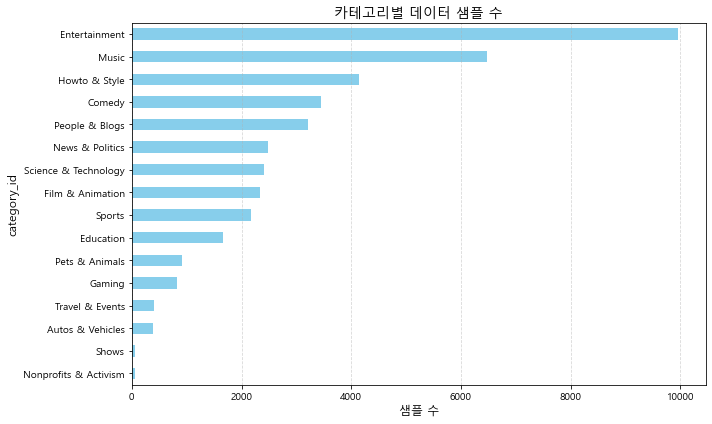

In [22]:
plt.figure(figsize=(10, 6))
category_counts.plot(kind='barh', color='skyblue')

plt.title("카테고리별 데이터 샘플 수", fontsize=14)
plt.xlabel("샘플 수", fontsize=12)
plt.ylabel("category_id", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [23]:
# BERT embedding에 category 결합
category_df['title_embedding'] = list(embeddings)

C:\Users\user\AppData\Local\Temp\ipykernel_2684\3614589385.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  category_df['title_embedding'] = list(embeddings)


Howto&style 파라미터튜닝(랜덤서치 사용)

In [24]:
# category filtering
cat_name = "Howto & Style"
group = category_df[category_df['category_id'] == 26]

X = np.vstack(group['title_embedding'].values)
y = group['log_views']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

Howto&style - Lasso(랜덤서치)

In [25]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import loguniform

# 1. 모델 정의
lasso = Lasso(random_state=42, max_iter=10000)

# 2. 탐색할 하이퍼파라미터 범위 정의
param_distributions = {
    'alpha': loguniform(1e-5, 10)  # 로그 스케일로 탐색
}

# 3. RandomizedSearchCV
random_search_lasso = RandomizedSearchCV(
    lasso,
    param_distributions=param_distributions,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

# 4. 학습
random_search_lasso.fit(X_train, y_train)

# 5. 예측 및 평가
y_pred = random_search_lasso.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
spearman_corr = spearmanr(y_test, y_pred).correlation if np.std(y_pred) > 0 else np.nan

# 6. 결과 출력
print("Category:", cat_name)
print("Model: Lasso (randomSearch)")
print("Best alpha for Lasso:", random_search_lasso.best_params_)
print("RMSE:", round(rmse, 4))
print("R²:", round(r2, 4))
print("Spearman:", "NaN" if np.isnan(spearman_corr) else round(spearman_corr, 4))

# 7. 결과 저장
lasso_random_df = pd.DataFrame([{
    "Category": cat_name,
    "Model": "Lasso (random search)",
    "Alpha": random_search_lasso.best_params_['alpha'],
    "RMSE": rmse,
    "R²": r2,
    "Spearman": spearman_corr
}])


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Category: Howto & Style
Model: Lasso (randomSearch)
Best alpha for Lasso: {'alpha': 1.8997763474111278e-05}
RMSE: 0.616
R²: 0.7916
Spearman: 0.9461


C:\Users\user\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.103e+01, tolerance: 5.771e-01
  model = cd_fast.enet_coordinate_descent(


Howto&style - Linear Regression

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr

# LinearRegression 모델 정의 및 학습
linear = LinearRegression()
linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)

# 성능 지표 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
spearman_corr = spearmanr(y_test, y_pred).correlation if np.std(y_pred) > 0 else np.nan

# 결과 출력
print("Category:", cat_name)
print("Model: LinearRegression")
print("RMSE:", round(rmse, 4))
print("R²:", round(r2, 4))
print("Spearman:", "NaN" if np.isnan(spearman_corr) else round(spearman_corr, 4))

# 결과 저장
linear_results_df = pd.DataFrame([{
    "Category": cat_name,
    "Model": "LinearRegression",
    "Alpha": None,
    "RMSE": rmse,
    "R²": r2,
    "Spearman": spearman_corr
}])


Category: Howto & Style
Model: LinearRegression
RMSE: 0.577
R²: 0.8171
Spearman: 0.9453


Howto&style - Ridge(랜덤서치)

In [27]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import loguniform 
from tqdm import tqdm

 # 로그 스케일 사용


# 1. 파라미터 분포 정의
param_dist = {
    'alpha': loguniform(1e-5, 10)
}

# 2. 모델 및 랜덤 서치 설정
ridge = Ridge()
randomsearch_ridge = RandomizedSearchCV(
    ridge,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

# 3. 학습
randomsearch_ridge.fit(X_train, y_train)

# 4. 예측 및 평가
y_pred = randomsearch_ridge.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
spearman_corr = spearmanr(y_test, y_pred).correlation if np.std(y_pred) > 0 else np.nan

# 5. 결과 출력
print("Category:", cat_name)
print("Model: Ridge (RandomizedSearch)")
print("Best alpha:", randomsearch_ridge.best_params_['alpha'])
print("RMSE:", round(rmse, 4))
print("R²:", round(r2, 4))
print("Spearman:", "NaN" if np.isnan(spearman_corr) else round(spearman_corr, 4))

# 6. 저장
ridge_random_df = pd.DataFrame([{
    "Category": cat_name,
    "Model": "Ridge (random)",
    "Alpha": randomsearch_ridge.best_params_['alpha'],
    "RMSE": rmse,
    "R²": r2,
    "Spearman": spearman_corr
}])


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Category: Howto & Style
Model: Ridge (RandomizedSearch)
Best alpha: 0.17718847354806813
RMSE: 0.5503
R²: 0.8336
Spearman: 0.9456


Howto&style - RF(랜덤서치)

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# 1. 하이퍼파라미터 탐색 공간 정의
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(5, 30),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2']
}

# 2. 모델 및 랜덤 서치 정의
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
randomsearch_rf = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# 3. 학습
randomsearch_rf.fit(X_train, y_train)

# 4. 예측 및 평가
y_pred = randomsearch_rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
spearman_corr = spearmanr(y_test, y_pred).correlation if np.std(y_pred) > 0 else np.nan

# 5. 출력
print("Category:", cat_name)
print("Model: Random Forest (RandomizedSearch)")
print("Best params:", randomsearch_rf.best_params_)
print("RMSE:", round(rmse, 4))
print("R²:", round(r2, 4))
print("Spearman:", "NaN" if np.isnan(spearman_corr) else round(spearman_corr, 4))

# 6. 결과 저장
rf_random_df = pd.DataFrame([{
    "Category": cat_name,
    "Model": "RandomForest (random)",
    "Alpha": None,
    "RMSE": rmse,
    "R²": r2,
    "Spearman": spearman_corr
}])


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Category: Howto & Style
Model: Random Forest (RandomizedSearch)
Best params: {'max_depth': 29, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 234}
RMSE: 0.4337
R²: 0.8967
Spearman: 0.963


Howto&style - gradient(랜덤서치)

In [1]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# 1. 하이퍼파라미터 분포 정의
param_dist = {
    'n_estimators': randint(100, 300),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 10),
    'subsample': uniform(0.6, 0.4)  # 0.6 ~ 1.0
}

# 2. 모델과 랜덤 서치 설정
gbr = GradientBoostingRegressor(random_state=42)
randomsearch_gbr = RandomizedSearchCV(
    gbr,
    param_distributions=param_dist,
    n_iter=30,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# 3. 모델 학습
randomsearch_gbr.fit(X_train, y_train)

# 4. 예측 및 평가
y_pred = randomsearch_gbr.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
spearman_corr = spearmanr(y_test, y_pred).correlation if np.std(y_pred) > 0 else np.nan

# 5. 결과 출력
print("Category:", cat_name)
print("Model: GradientBoosting (RandomizedSearch)")
print("Best params:", randomsearch_gbr.best_params_)
print("RMSE:", round(rmse, 4))
print("R²:", round(r2, 4))
print("Spearman:", "NaN" if np.isnan(spearman_corr) else round(spearman_corr, 4))

# 6. 결과 저장
gbr_random_df = pd.DataFrame([{
    "Category": cat_name,
    "Model": "GradientBoosting (random)",
    "Alpha": None,
    "RMSE": rmse,
    "R²": r2,
    "Spearman": spearman_corr
}])


NameError: name 'X_train' is not defined

In [ ]:
# 모델별 결과 DataFrame 합치기
all_results = pd.concat([
    lasso_random_df,
    linear_results_df,
    ridge_random_df,
    rf_random_df,
    gbr_random_df
], ignore_index=True)

In [ ]:
#시각화를 위한 변환 (wide → long)
results_long = all_results.melt(
    id_vars="Model", 
    value_vars=["RMSE", "R²", "Spearman"],
    var_name="Metric", 
    value_name="Score"
)

# 선 그래프(line chart)로 시각화
plt.figure(figsize=(10, 6))
for metric in results_long["Metric"].unique():
    subset = results_long[results_long["Metric"] == metric]
    plt.plot(subset["Model"], subset["Score"], marker='o', label=metric)

plt.title("Model Performance Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metric")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 성능 지표 기준으로 정렬 (예: RMSE 기준 오름차순 정렬)
all_results_random_df_sorted = all_results_random_df.sort_values(by="RMSE")

# 테이블 출력
import pandas as pd
from IPython.display import display

display(all_results_random_df_sorted)